In [2]:
import numpy as np # linear algebra
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings 
import copy 

In [3]:
import pickle

# 加载数据

with open('ehr_preprocessed_seq_by_day_cat_embedding.pkl', 'rb') as f:
  ehr_data = pickle.load(f)

ehr_data.keys()

dict_keys(['feat_dict', 'feature_cols', 'cat_idxs', 'cat_dims', 'demo_cols', 'icd_cols', 'lab_cols', 'med_cols'])

In [4]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

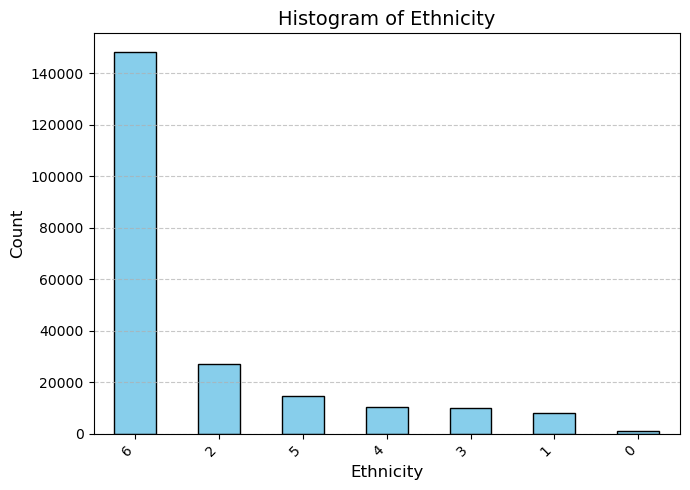

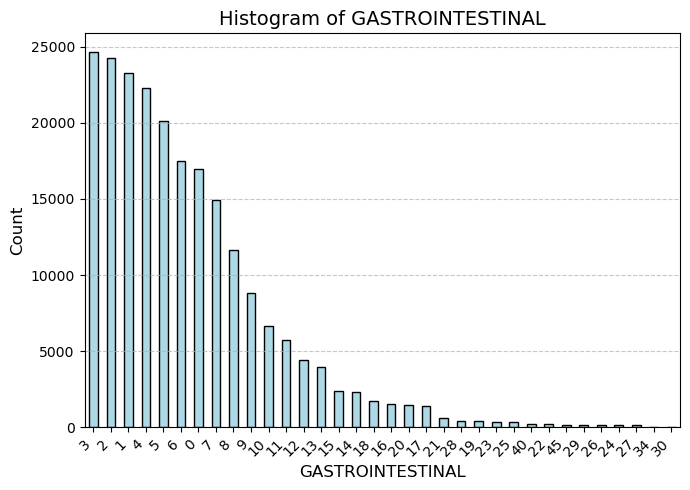

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "ehr_preprocessed_seq_by_day_cat_embedding.csv"
data = pd.read_csv(file_path)

# Plot histogram for the 'ethnicity' column
plt.figure(figsize=(7, 5))
data['ethnicity'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Histogram of Ethnicity', fontsize=14)
plt.xlabel('Ethnicity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot histogram for the 'GASTROINTESTINAL' column
plt.figure(figsize=(7, 5))
data['GASTROINTESTINAL'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Histogram of GASTROINTESTINAL', fontsize=14)
plt.xlabel('GASTROINTESTINAL', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import find_peaks

# -------- Step 1: Custom Dataset Class -------- #

class CustomDataset(Dataset):
    def __init__(self, dataframe, feat_dict):
        """
        Custom PyTorch Dataset to handle feature extraction and normalization.
        :param dataframe: Pandas DataFrame with patient IDs and labels.
        :param feat_dict: Dictionary mapping patient IDs to their feature arrays.
        """
        self.df = dataframe.drop_duplicates(subset=['id'], keep='first')  # Ensure unique IDs
        self.feat_dict = feat_dict
        self.mean, self.std = self.compute_stats()  # Compute mean and std for normalization

    def compute_stats(self):
        """
        Compute the mean and standard deviation across all features for normalization.
        """
        selected_features = torch.cat([torch.tensor(self.feat_dict[id][:, :], dtype=torch.float32)
                                       for id in self.df['id']])
        mean = selected_features.mean(dim=0)
        std = selected_features.std(dim=0)
        return mean, std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieve a data sample (features and label) by index.
        """
        row = self.df.iloc[idx]
        features = torch.tensor(self.feat_dict[row['id']][:, :], dtype=torch.float32)
        label = row['readmitted_within_30days'] if 'readmitted_within_30days' in self.df.columns else -1

        # Normalize features
        features = (features - self.mean) / (self.std + 1e-6)  # Avoid division by zero
        return features, torch.tensor(label, dtype=torch.long)


# -------- Step 2: Feature Extraction Functions -------- #

def extract_statistical_features(features):
    """
    Extract enhanced statistical features from time-series data.
    :param features: Tensor of shape (time_steps, num_features)
    :return: Tensor of shape (num_features * num_statistics,)
    """
    features_np = features.numpy()

    # Basic statistics
    mean = features.mean(dim=0)
    std = features.std(dim=0)
    min_val = features.min(dim=0).values
    max_val = features.max(dim=0).values
    var = features.var(dim=0)
    median = torch.median(features, dim=0).values
    range_val = max_val - min_val

    # Advanced statistics
    skewness = torch.tensor(skew(features_np, axis=0, nan_policy='omit'))
    kurt = torch.tensor(kurtosis(features_np, axis=0, nan_policy='omit'))
    energy = torch.sum(features ** 2, dim=0)

    # Safeguard for entropy: Ensure no negative or zero values
    features_np_safe = np.clip(features_np, a_min=1e-12, a_max=None)
    signal_entropy = torch.tensor(entropy(features_np_safe.T, axis=1))

    # Concatenate all statistical features
    statistics = torch.cat([mean, std, min_val, max_val, var, median, range_val, skewness, kurt, energy, signal_entropy], dim=0)

    # Replace NaN, inf, or -inf with 0
    statistics[~torch.isfinite(statistics)] = 0

    return statistics


def extract_temporal_features(features):
    """
    Extract temporal features from time-series data.
    :param features: Tensor of shape (time_steps, num_features)
    :return: Tensor of shape (num_features * num_temporal_features,)
    """
    features_np = features.numpy()

    # Autocorrelation for lag 1 (handle errors gracefully)
    autocorr = []
    for i in range(features_np.shape[1]):
        try:
            autocorr_value = np.corrcoef(features_np[:-1, i], features_np[1:, i])[0, 1]
        except:
            autocorr_value = 0  # Default to 0 if computation fails
        autocorr.append(autocorr_value)
    autocorr = torch.tensor(autocorr)

    # Rolling mean (window size = 3)
    rolling_mean = torch.tensor(pd.DataFrame(features_np).rolling(window=3, min_periods=1).mean().iloc[-1].values)

    # Peak detection
    peaks = torch.tensor([len(find_peaks(features_np[:, i])[0]) for i in range(features_np.shape[1])])

    # Combine temporal features
    temporal_features = torch.cat([autocorr, rolling_mean, peaks], dim=0)

    # Replace NaN, inf, or -inf with 0
    temporal_features[~torch.isfinite(temporal_features)] = 0

    return temporal_features


def extract_features(features):
    """
    Combines statistical and temporal features for feature extraction.
    :param features: Tensor of shape (time_steps, num_features)
    :return: Tensor of combined features
    """
    statistical_features = extract_statistical_features(features)
    temporal_features = extract_temporal_features(features)
    combined_features = torch.cat([statistical_features, temporal_features], dim=0)
    return combined_features


# -------- Step 3: Batch Feature Extraction -------- #

def clean_features(features):
    """
    Ensures that all feature values are finite (no inf, -inf, or NaN).
    :param features: NumPy array of extracted features
    :return: Cleaned NumPy array
    """
    # Replace NaN, inf, and -inf with 0
    features[~np.isfinite(features)] = 0
    return features


def extract_features_and_labels(dataset, batch_size=128):
    """
    Extract features and labels from a PyTorch Dataset in batches.
    :param dataset: PyTorch Dataset object
    :param batch_size: Number of samples per batch
    :return: features_array, labels_array
    """
    features_list = []
    labels_list = []

    for i in range(0, len(dataset), batch_size):
        batch = [dataset[j] for j in range(i, min(i + batch_size, len(dataset)))]
        features_batch = torch.stack([extract_features(features) for features, _ in batch])
        labels_batch = torch.tensor([label for _, label in batch])

        # Convert features to NumPy and clean them
        features_cleaned = clean_features(features_batch.numpy())
        features_list.append(features_cleaned)
        labels_list.append(labels_batch.numpy())

    features_array = np.concatenate(features_list)
    labels_array = np.concatenate(labels_list)

    return features_array, labels_array


# -------- Step 4: Feature Scaling -------- #

def scale_features(train_features, valid_features, test_features):
    """
    Scale features using StandardScaler.
    """
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    valid_features_scaled = scaler.transform(valid_features)
    test_features_scaled = scaler.transform(test_features)
    return train_features_scaled, valid_features_scaled, test_features_scaled


# -------- Main Workflow -------- #

# Assuming ehr_data, df_train, df_valid, df_test are already loaded
feat_dict = ehr_data['feat_dict']

# Create PyTorch Dataset objects
train_dataset = CustomDataset(df_train, feat_dict)
valid_dataset = CustomDataset(df_valid, feat_dict)
test_dataset = CustomDataset(df_test, feat_dict)

# Extract features and labels
train_features, train_labels = extract_features_and_labels(train_dataset)
valid_features, valid_labels = extract_features_and_labels(valid_dataset)
test_features, test_labels = extract_features_and_labels(test_dataset)

# Ensure all features are finite (clean again after extraction)
train_features = clean_features(train_features)
valid_features = clean_features(valid_features)
test_features = clean_features(test_features)

# Scale features
train_features_scaled, valid_features_scaled, test_features_scaled = scale_features(
    train_features, valid_features, test_features
)

# At this point, you have:
# - `train_features_scaled`, `valid_features_scaled`, `test_features_scaled`: Scaled feature arrays
# - `train_labels`, `valid_labels`, `test_labels`: Corresponding labels

/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_17508/2280458276.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return features, torch.tensor(label, dtype=torch.long)
/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_17508/2280458276.py:68: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = torch.tensor(skew(features_np, axis=0, nan_policy='omit'))
/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_17508/2280458276.py:69: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = torch.tensor(kurtosis(features_np, axis=0, nan_policy='omit'))
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarn

In [7]:
# -------- Calculate Total Number of Features -------- #

# Extract features for a single sample from the training dataset
sample_features, _ = train_dataset[0]  # Get the first sample from the train dataset
extracted_features = extract_features(sample_features)  # Extract features for this sample

# Calculate the total number of features
total_features = len(extracted_features)

print(f"Total number of features: {total_features}")

Total number of features: 2394


/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_17508/2280458276.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return features, torch.tensor(label, dtype=torch.long)
/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_17508/2280458276.py:68: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = torch.tensor(skew(features_np, axis=0, nan_policy='omit'))
/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_17508/2280458276.py:69: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = torch.tensor(kurtosis(features_np, axis=0, nan_policy='omit'))
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarn

In [8]:
def extract_label(patient_data):
    return patient_data['label']

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  13.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; tota

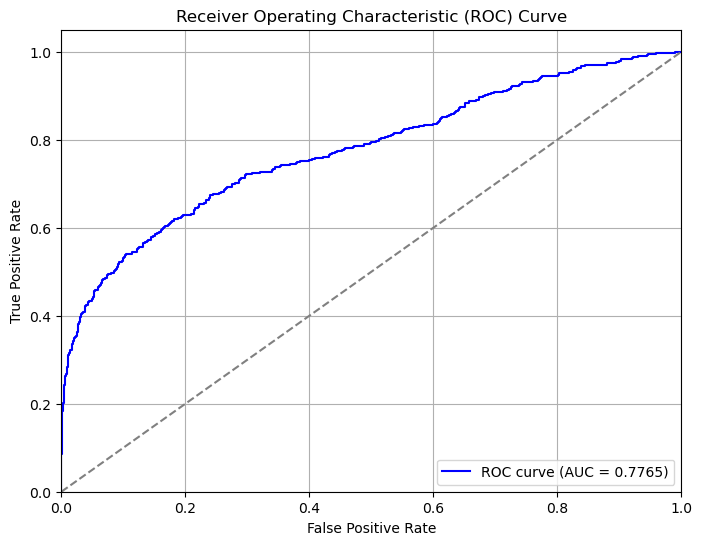

In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# -------- Step 1: Feature Scaling -------- #

# Scaling features (although not necessary for Random Forest, it's good practice in many cases)
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and validation data
train_features_scaled = scaler.fit_transform(train_features)
valid_features_scaled = scaler.transform(valid_features)

# -------- Step 2: Hyperparameter Tuning to Prevent Overfitting -------- #

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],               # Number of trees, start with 100 and 200
    'max_depth': [10, 15, 20],                # Limit tree depth to avoid overfitting
    'min_samples_split': [5, 10, 15],         # Increase the minimum number of samples to split a node
    'min_samples_leaf': [4, 6, 8],            # Increase the minimum number of samples required at a leaf node
    'max_features': ['sqrt', 'log2'],         # Consider a random subset of features at each split
    'bootstrap': [True]                       # Use bootstrap samples (default)
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Use GridSearchCV to find the best hyperparameters while preventing overfitting
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='roc_auc',                        # Optimize on ROC-AUC score
    cv=StratifiedKFold(n_splits=5),           # Use 5-fold cross-validation
    verbose=2,
    n_jobs=-1                                 # Use all available CPU cores
)

# Train the GridSearchCV model on the training data
grid_search.fit(train_features_scaled, train_labels)

# Get the best model from the search
best_rf_model = grid_search.best_estimator_

print(f"Best hyperparameters found: {grid_search.best_params_}")

# -------- Step 3: Evaluate the Best Model on the Validation Set -------- #

# Predict probabilities for the validation set with the best model
valid_pred_prob = best_rf_model.predict_proba(valid_features_scaled)[:, 1]

# Compute ROC-AUC for the Random Forest model on the validation set
roc_auc_valid = roc_auc_score(valid_labels, valid_pred_prob)
print(f"ROC-AUC on the validation set with tuned model: {roc_auc_valid:.4f}")

# -------- Step 4: Plotting the ROC Curve -------- #

# Compute False Positive Rate (fpr), True Positive Rate (tpr) and thresholds
fpr, tpr, thresholds = roc_curve(valid_labels, valid_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc_valid:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Show the plot
plt.show()

Top 10 Features and Their Importances:
                           Feature  Importance
2181     GASTROINTESTINAL_autocorr    0.017223
2148        MUSCLE RELAXANTS_range    0.016704
2175       GASTROINTESTINAL_median    0.016262
129                    R00-R09_max    0.010061
96            C60-C63_rolling_mean    0.008975
1635  Eosinophils Pleural_autocorr    0.008546
2151       MUSCLE RELAXANTS_energy    0.007563
1668         Bicarbonate Blood_min    0.007493
783                  R10-R19_peaks    0.006661
119               M80-M85_skewness    0.006534


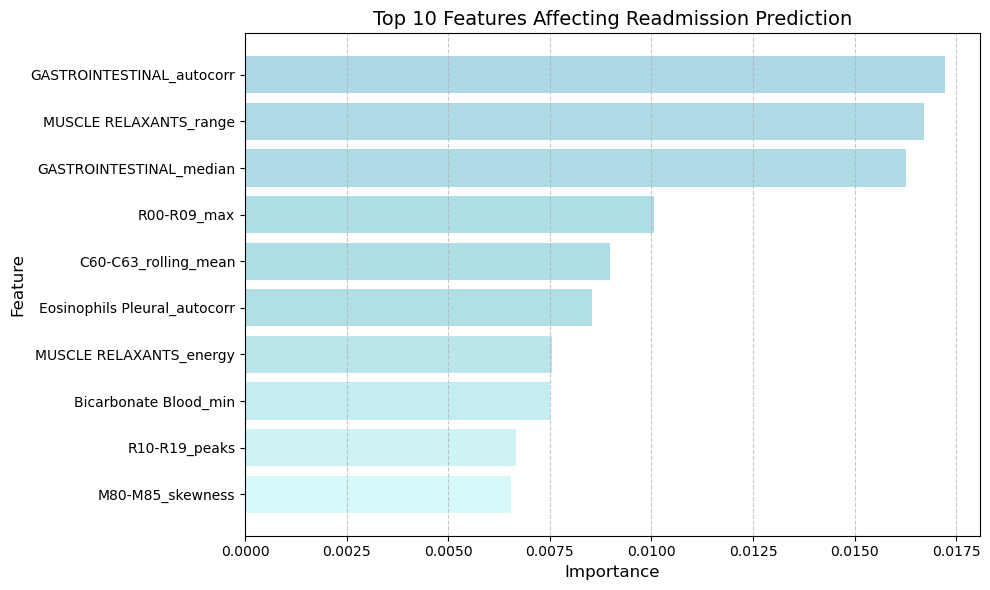

In [39]:
# -------- Step 5: Feature Importance -------- #

# Step 1: Feature importances from the trained Random Forest model
# Ensure the model is trained
try:
    feature_importances = best_rf_model.feature_importances_
except AttributeError as e:
    print("Error: The model is not fitted yet. Train the model before accessing feature importances.")
    raise e

# Step 2: Generate detailed feature names (if applicable)
# Ensure 'ehr_data' and 'feature_cols' are defined
if 'feature_cols' in ehr_data:
    detailed_feature_names = []
    for name in ehr_data['feature_cols']:
        detailed_feature_names.extend([
            f"{name}_mean",
            f"{name}_std",
            f"{name}_min",
            f"{name}_max",
            f"{name}_var",
            f"{name}_median",
            f"{name}_range",
            f"{name}_skewness",
            f"{name}_kurtosis",
            f"{name}_energy",
            f"{name}_entropy",
            f"{name}_autocorr",
            f"{name}_rolling_mean",
            f"{name}_peaks"
        ])
else:
    print("Error: 'feature_cols' not found in 'ehr_data'.")
    raise KeyError("Missing 'feature_cols' in ehr_data.")

# Ensure the number of feature names matches the number of features in the model
if len(detailed_feature_names) >= len(feature_importances):
    feature_names = detailed_feature_names[:len(feature_importances)]
else:
    print("Error: Mismatch between detailed feature names and feature importances.")
    raise ValueError(f"Number of feature names ({len(detailed_feature_names)}) "
                     f"does not match number of features ({len(feature_importances)}).")

# Step 3: Map feature importances to their names
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Step 4: Print and plot the top 10 features
top_10_features = feature_importance_df.head(10)
print("Top 10 Features and Their Importances:")
print(top_10_features)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Custom colormap for soft light-blue gradient
light_blue_gradient = mcolors.LinearSegmentedColormap.from_list(
    "light_blue_gradient", ["#add8e6", "#b0e0e6", "#e0ffff"]  # Light blue shades
)

# Generate a gradient of soft light blue shades
colors = [light_blue_gradient(i / len(top_10_features)) for i in range(len(top_10_features))]

# Plot the top 10 features with a gradient of light blue shades
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color=colors)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Features Affecting Readmission Prediction', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# -------- Step 1: Ensure Unique IDs in Test Data -------- #

# Drop duplicate IDs in the test set
df_test_unique = df_test.drop_duplicates(subset=['id'], keep='first')

# Extract features from the test dataset (assuming you've already defined the extract_features_and_labels function)
# Since test.csv does not contain labels, we pass '_' for labels
test_features, _ = extract_features_and_labels(test_dataset)

# -------- Step 2: Scale the Test Features -------- #

# Use the same scaler fitted on the training data to scale the test features
test_features_scaled = scaler.transform(test_features)

# -------- Step 3: Predict Readmission Probabilities -------- #

# Predict probabilities for the test set using the trained Random Forest model
# We are interested in the probability of the positive class (class 1)
test_pred_prob = best_rf_model.predict_proba(test_features_scaled)[:, 1]

# -------- Step 4: Save Predictions to CSV -------- #

# Create a DataFrame with 'id' and 'probability_of_readmission'
test_predictions_df = pd.DataFrame({
    'id': df_test_unique['id'],
    'probability_of_readmission': test_pred_prob
})

# Save the predictions to a CSV file
output_csv_filename = 'Random_Forest_prediction_updatedfeature.csv'
test_predictions_df.to_csv(output_csv_filename, index=False)

print(f"Predictions saved to {output_csv_filename}")

/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_44838/2280458276.py:68: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = torch.tensor(skew(features_np, axis=0, nan_policy='omit'))
/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_44838/2280458276.py:69: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = torch.tensor(kurtosis(features_np, axis=0, nan_policy='omit'))
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Predictions saved to Random_Forest_prediction_updatedfeature.csv


ROC-AUC on the validation set (Extra Trees): 0.7720


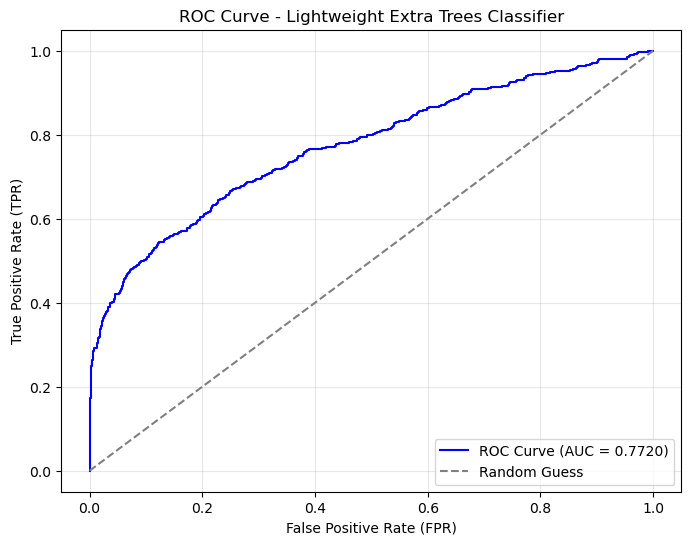

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# -------- Step 6: Train a Lightweight and Accurate Extra Trees Classifier -------- #

# Initialize the Extra Trees Classifier with balanced parameters
et_model = ExtraTreesClassifier(
    n_estimators=150,         # Slightly more trees for better ensemble performance
    max_depth=15,             # Moderate depth to prevent overfitting
    min_samples_split=5,      # Minimum number of samples to split a node
    min_samples_leaf=3,       # Minimum samples per leaf node for regularization
    max_features='sqrt',      # Use sqrt of the total features for split decisions
    random_state=42,          # For reproducibility
    class_weight='balanced'   # Handle class imbalance
)

# Train the model on the scaled training data
et_model.fit(train_features_scaled, train_labels)

# Predict probabilities for the validation set
valid_pred_prob = et_model.predict_proba(valid_features_scaled)[:, 1]

# Compute the ROC-AUC score on the validation set
roc_auc_valid = roc_auc_score(valid_labels, valid_pred_prob)
print(f"ROC-AUC on the validation set (Extra Trees): {roc_auc_valid:.4f}")

# -------- Step 7: Plot the ROC Curve -------- #

# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(valid_labels, valid_pred_prob)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_valid:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')  # Diagonal line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Lightweight Extra Trees Classifier')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# -------- Step 1: Ensure Unique IDs in Test Data -------- #

# Drop duplicate IDs in the test set
df_test_unique = df_test.drop_duplicates(subset=['id'], keep='first')

# Extract features from the test dataset (assuming you've already defined the extract_features_and_labels function)
# Since test.csv does not contain labels, we pass '_' for labels
test_features, _ = extract_features_and_labels(test_dataset)

# -------- Step 2: Scale the Test Features -------- #

# Use the same scaler fitted on the training data to scale the test features
test_features_scaled = scaler.transform(test_features)

# -------- Step 3: Predict Readmission Probabilities -------- #

# Predict probabilities for the test set using the trained Extra Trees model
# We are interested in the probability of the positive class (class 1)
test_pred_prob = et_model.predict_proba(test_features_scaled)[:, 1]

# -------- Step 4: Save Predictions to CSV -------- #

# Create a DataFrame with 'id' and 'probability_of_readmission'
test_predictions_df = pd.DataFrame({
    'id': df_test_unique['id'],
    'probability_of_readmission': test_pred_prob
})

# Save the predictions to a CSV file
output_csv_filename = 'Extra_Trees_prediction_updatedfeature.csv'
test_predictions_df.to_csv(output_csv_filename, index=False)

print(f"Predictions saved to {output_csv_filename}")

/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_19853/2280458276.py:68: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = torch.tensor(skew(features_np, axis=0, nan_policy='omit'))
/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_19853/2280458276.py:69: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = torch.tensor(kurtosis(features_np, axis=0, nan_policy='omit'))
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Predictions saved to Extra_Trees_prediction_updatedfeature.csv


/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ROC-AUC on the validation set: 0.7790


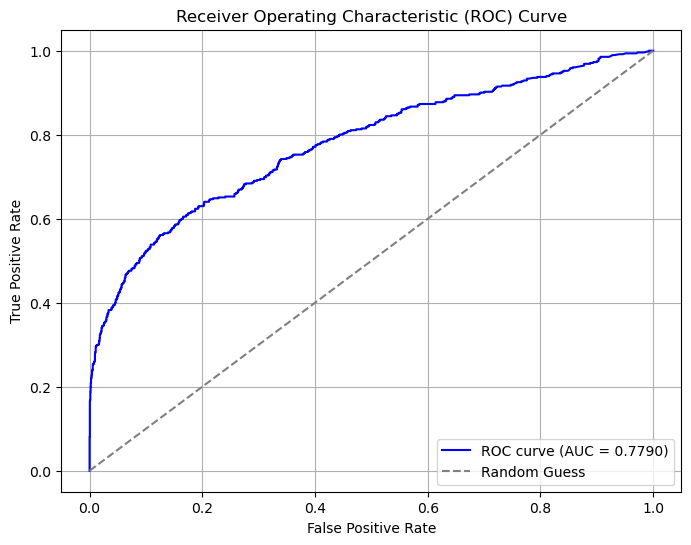

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# -------- Step 1: Initialize the AdaBoost Model -------- #

# Use a DecisionTreeClassifier with a depth of 1 as the base estimator
adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # Weak learner (use 'estimator' instead of 'base_estimator')
    n_estimators=100,  # Number of weak learners
    learning_rate=0.1,  # Learning rate
    random_state=42  # For reproducibility
)

# -------- Step 2: Train the Model -------- #

# Train the AdaBoost model on the scaled training data
adaboost_model.fit(train_features_scaled, train_labels)

# -------- Step 3: Evaluate the Model -------- #

# Predict probabilities for the validation set
valid_pred_prob = adaboost_model.predict_proba(valid_features_scaled)[:, 1]

# Compute the ROC-AUC score on the validation set
roc_auc_valid = roc_auc_score(valid_labels, valid_pred_prob)
print(f"ROC-AUC on the validation set: {roc_auc_valid:.4f}")

# -------- Step 4: Plot the ROC Curve -------- #

# Compute the ROC curve for the validation set
fpr, tpr, thresholds = roc_curve(valid_labels, valid_pred_prob)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc_valid:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -------- Step 1: Ensure Unique IDs in Test Data -------- #

# Drop duplicate IDs in the test set
df_test_unique = df_test.drop_duplicates(subset=['id'], keep='first')

# Extract features and IDs from the test dataset
# Using the previously defined function `extract_features_and_labels_with_ids`
test_features, _ = extract_features_and_labels(test_dataset)

# -------- Step 2: Scale the Test Features -------- #

# Use the same scaler that was fitted on the training data to scale the test features
test_features_scaled = scaler.transform(test_features)

# -------- Step 3: Predict Readmission Probabilities -------- #

# Predict probabilities for the test set using the trained AdaBoost model
# We are interested in the probability of the positive class (class 1)
predicted_probabilities_test = adaboost_model.predict_proba(test_features_scaled)[:, 1]

# -------- Step 4: Check Consistency Between IDs and Predictions -------- #

# Check that the number of unique IDs matches the number of predictions
print(f"Number of unique IDs: {df_test_unique.shape[0]}")
print(f"Number of predictions: {len(predicted_probabilities_test)}")

if df_test_unique.shape[0] != len(predicted_probabilities_test):
    raise ValueError("Mismatch between the number of unique IDs and the number of predictions.")

# -------- Step 5: Save Predictions to CSV -------- #

# Create a DataFrame with 'id' and 'probability_of_readmission'
test_predictions_df = pd.DataFrame({
    'id': df_test_unique['id'],
    'probability_of_readmission': predicted_probabilities_test
})

# Save the predictions to a CSV file
output_csv_filename = 'AdaBoost_predictions.csv'
test_predictions_df.to_csv(output_csv_filename, index=False)

print(f"Predictions saved to {output_csv_filename}")

/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_19853/2280458276.py:68: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = torch.tensor(skew(features_np, axis=0, nan_policy='omit'))
/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_19853/2280458276.py:69: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = torch.tensor(kurtosis(features_np, axis=0, nan_policy='omit'))
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Number of unique IDs: 2741
Number of predictions: 2741
Predictions saved to AdaBoost_predictions.csv


Epoch 1/20, Train Loss: 0.0071, Valid Loss: 0.3829
Epoch 2/20, Train Loss: 0.0055, Valid Loss: 0.3634
Epoch 3/20, Train Loss: 0.0050, Valid Loss: 0.3626
Epoch 4/20, Train Loss: 0.0045, Valid Loss: 0.3684
Epoch 5/20, Train Loss: 0.0040, Valid Loss: 0.3842
Epoch 6/20, Train Loss: 0.0036, Valid Loss: 0.4070
Epoch 7/20, Train Loss: 0.0032, Valid Loss: 0.4272
Epoch 8/20, Train Loss: 0.0028, Valid Loss: 0.4475
Epoch 9/20, Train Loss: 0.0025, Valid Loss: 0.4952
Epoch 10/20, Train Loss: 0.0022, Valid Loss: 0.5330
Epoch 11/20, Train Loss: 0.0020, Valid Loss: 0.5785
Epoch 12/20, Train Loss: 0.0017, Valid Loss: 0.6200
Epoch 13/20, Train Loss: 0.0017, Valid Loss: 0.6479
Epoch 14/20, Train Loss: 0.0017, Valid Loss: 0.6156
Epoch 15/20, Train Loss: 0.0016, Valid Loss: 0.6541
Epoch 16/20, Train Loss: 0.0014, Valid Loss: 0.6891
Epoch 17/20, Train Loss: 0.0012, Valid Loss: 0.7359
Epoch 18/20, Train Loss: 0.0011, Valid Loss: 0.7498
Epoch 19/20, Train Loss: 0.0011, Valid Loss: 0.7602
Epoch 20/20, Train Lo

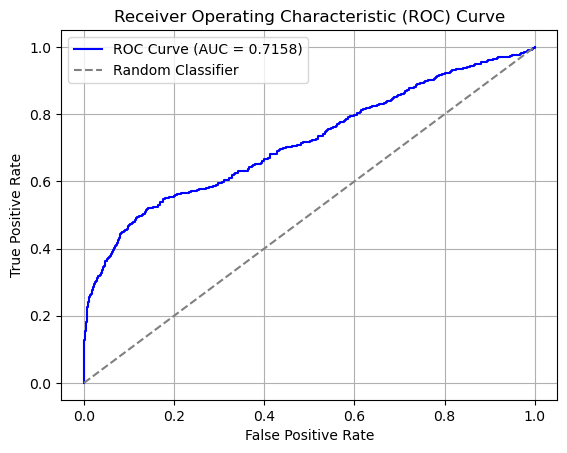

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# -------- Step 1: LSTM Model Definition -------- #

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        """
        LSTM model for sequence classification.
        :param input_dim: Number of input features
        :param hidden_dim: Number of hidden units in LSTM
        :param output_dim: Number of output classes (binary classification -> 1)
        :param num_layers: Number of LSTM layers
        :param dropout: Dropout rate
        """
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()  # Apply sigmoid for binary classification

    def forward(self, x):
        """
        Forward pass of the LSTM model.
        :param x: Input tensor of shape (batch_size, time_steps, input_dim)
        :return: Output logits of shape (batch_size, 1)
        """
        lstm_out, _ = self.lstm(x)  # LSTM output
        last_hidden_state = lstm_out[:, -1, :]  # Take the last time step
        output = self.fc(last_hidden_state)  # Fully connected layer
        output = self.sigmoid(output)  # Apply sigmoid activation
        return output


# -------- Step 2: Prepare Data for Training and Validation -------- #

# Convert features and labels into PyTorch tensors
train_features_tensor = torch.tensor(train_features_scaled, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)  # Add extra dimension for binary labels
valid_features_tensor = torch.tensor(valid_features_scaled, dtype=torch.float32)
valid_labels_tensor = torch.tensor(valid_labels, dtype=torch.float32).unsqueeze(1)

# Reshape features into (batch_size, time_steps, input_dim)
# Assuming each sequence has 1 time step (as features are extracted for each patient)
train_features_tensor = train_features_tensor.unsqueeze(1)  # Shape: (num_samples, 1, input_dim)
valid_features_tensor = valid_features_tensor.unsqueeze(1)  # Shape: (num_samples, 1, input_dim)

# -------- Step 3: Model Training -------- #

# Hyperparameters
input_dim = train_features_tensor.shape[2]  # Number of input features
hidden_dim = 64  # Number of LSTM hidden units
output_dim = 1  # Binary classification
num_layers = 2  # Number of LSTM layers
dropout = 0.2  # Dropout rate
lr = 0.001  # Learning rate
num_epochs = 20  # Number of training epochs
batch_size = 64  # Batch size

# Initialize model, loss, and optimizer
model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, dropout=dropout)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for i in range(0, train_features_tensor.size(0), batch_size):
        batch_x = train_features_tensor[i:i+batch_size]
        batch_y = train_labels_tensor[i:i+batch_size]

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        output = model(valid_features_tensor)
        valid_loss = criterion(output, valid_labels_tensor).item()

    # Save losses for plotting
    train_losses.append(train_loss / len(train_features_tensor))
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")


# -------- Step 4: Evaluate Model with ROC-AUC -------- #

# Get predictions on validation set
model.eval()
with torch.no_grad():
    valid_preds = model(valid_features_tensor).squeeze().numpy()  # Predicted probabilities
    valid_labels = valid_labels_tensor.numpy()

# Calculate ROC-AUC
roc_auc = roc_auc_score(valid_labels, valid_preds)
print(f"Validation ROC-AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(valid_labels, valid_preds)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -------- Step 1: Ensure Unique IDs in Test Data -------- #

# Drop duplicate IDs in the test set
df_test_unique = df_test.drop_duplicates(subset=['id'], keep='first')

# Extract features and IDs from the test dataset
# Using the previously defined function `extract_features_and_labels`
test_features, _ = extract_features_and_labels(test_dataset)

# -------- Step 2: Scale the Test Features -------- #

# Use the same scaler that was fitted on the training data to scale the test features
test_features_scaled = scaler.transform(test_features)

# -------- Step 3: Predict Readmission Probabilities -------- #

# Convert scaled test features into PyTorch tensor
test_features_tensor = torch.tensor(test_features_scaled, dtype=torch.float32).unsqueeze(1)  # Add time dimension

# Predict probabilities for the test set using the trained LSTM model
# The output is the probability of the positive class (readmission within 30 days)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predicted_probabilities_test = model(test_features_tensor).squeeze().numpy()  # Predicted probabilities

# -------- Step 4: Check Consistency Between IDs and Predictions -------- #

# Check that the number of unique IDs matches the number of predictions
print(f"Number of unique IDs: {df_test_unique.shape[0]}")
print(f"Number of predictions: {len(predicted_probabilities_test)}")

if df_test_unique.shape[0] != len(predicted_probabilities_test):
    raise ValueError("Mismatch between the number of unique IDs and the number of predictions.")

# -------- Step 5: Save Predictions to CSV -------- #

# Create a DataFrame with 'id' and 'probability_of_readmission'
test_predictions_df = pd.DataFrame({
    'id': df_test_unique['id'].values,  # Ensure 'id' matches the unique IDs
    'probability_of_readmission': predicted_probabilities_test
})

# Save the predictions to a CSV file
output_csv_filename = 'LSTM_predictions.csv'
test_predictions_df.to_csv(output_csv_filename, index=False)

print(f"Predictions saved to {output_csv_filename}")

/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_44838/2280458276.py:68: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = torch.tensor(skew(features_np, axis=0, nan_policy='omit'))
/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_44838/2280458276.py:69: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = torch.tensor(kurtosis(features_np, axis=0, nan_policy='omit'))
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Number of unique IDs: 2741
Number of predictions: 2741
Predictions saved to LSTM_predictions.csv


ROC-AUC on the validation set (Naive Bayes): 0.4938


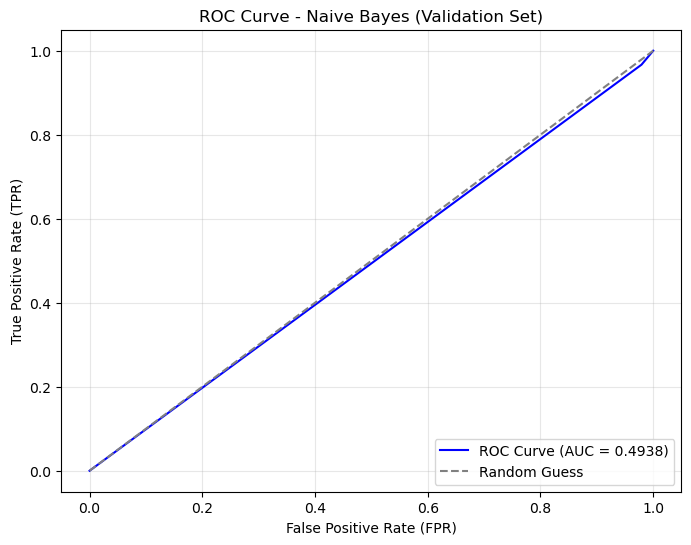

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# -------- Step 6: Train a Naive Bayes Model -------- #

# Initialize the Naive Bayes model
nb_model = GaussianNB()

# Train the model on the scaled training data
nb_model.fit(train_features_scaled, train_labels)

# Predict probabilities for the validation set
valid_pred_prob = nb_model.predict_proba(valid_features_scaled)[:, 1]

# Compute the ROC-AUC score on the validation set
roc_auc_valid = roc_auc_score(valid_labels, valid_pred_prob)
print(f"ROC-AUC on the validation set (Naive Bayes): {roc_auc_valid:.4f}")

# -------- Step 7: Plot the ROC Curve -------- #

# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(valid_labels, valid_pred_prob)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_valid:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')  # Diagonal line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Naive Bayes (Validation Set)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()